# Introducción

El objetivo de este notebook es aplicar todo lo aprendido sobre detección de sesgos y explicabilidad de modelos de inteligencia artificial, para ello se realizará la ingesta del dataset de Adultos, se analizará y preprocesará su información, se detectarán sesgos, y finalmente se entrenará, validará e intepretará un modelo de predicción robusto. Una vez realizados todos estos pasos, se explicarán diversas ideas para la mitigación de sesgos y se implementará una de ellas para comparar el rendimiento del anterior modelo respecto al nuevo.

# Dataset de Adultos

El dataset de Adultos, con el que se va a trabajar en esta práctica, se trata de un conjunto de datos tabular que almacena información sobre diversos aspectos socioeconómicos de personas adultas. En esta primera sección se realizará la ingesta de los datos para que estén disponibles en el entorno de ejecución del notebook y se llevará a cabo un análisis de su contenido con el propósito de familiarizarnos con su estructura y distribución.

## Ingesta

En primer lugar se lleva a cabo la ingesta del conjunto de datos de partida, para realizar la ingesta se descarga el dataset de un repositorio de google drive mediante un enlace público, una vez instalado en el entorno del notebook se carga todo su contenido en una estructura de información de tipo dataframe, consistente en una matriz de datos, mediante la librería Pandas.

In [ ]:
# Se importan las librerías necesarias para el entorno de ejecución
import pandas as pd

# Se descarga el conjunto de datos
!wget "https://drive.google.com/uc?export=download&id=1_nG8k23jOXd8WTsPQos-dKPyY994ULZu" -O 'dataset.csv'

# Mediante la librería pandas se construye un dataframe a partir del dataset descargado
dataframe = pd.read_csv('dataset.csv')

print(dataframe)

--2024-07-21 10:59:35--  https://drive.google.com/uc?export=download&id=1_nG8k23jOXd8WTsPQos-dKPyY994ULZu
Resolving drive.google.com (drive.google.com)... 172.217.7.46, 2607:f8b0:4025:815::200e
Connecting to drive.google.com (drive.google.com)|172.217.7.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1_nG8k23jOXd8WTsPQos-dKPyY994ULZu&export=download [following]
--2024-07-21 10:59:35--  https://drive.usercontent.google.com/download?id=1_nG8k23jOXd8WTsPQos-dKPyY994ULZu&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.12.1, 2607:f8b0:4025:815::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.12.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5326368 (5.1M) [application/octet-stream]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   5.08M  33.5MB/s    in 0.2s    

202

## Análisis Exploratorio de Datos

El análisis exploratorio de datos (EDA) es la etapa dedicada a conocer la naturaleza de los datos con los que se va a trabajar, para ello se utilizará el módulo EDAModule desarrollado por mí mismo y accesible a través del enlace de GitHub que se muestra en el código, a partir de este módulo se impartará la clase ExploratoryDataAnalysis con todas las funcionalidades necesarias para llevar a cabo el estudio de la estructura y distribución de la información.

In [ ]:
# Se importa el módulo con todas las funciones auxiliares
!rm -r ExploratoryDataAnalysis/

!git clone https://github.com/jj-tena/ExploratoryDataAnalysis.git

!mv ExploratoryDataAnalysis/EDAModule.py ExploratoryDataAnalysis/../EDAModule.py

!rm -r ExploratoryDataAnalysis/

from EDAModule import ExploratoryDataAnalysis

# Se inicializa el módulo mediante el dataframe
eda = ExploratoryDataAnalysis(dataset=dataframe)

rm: cannot remove 'ExploratoryDataAnalysis/': No such file or directory
Cloning into 'ExploratoryDataAnalysis'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 2), reused 15 (delta 1), pack-reused 0
Receiving objects: 100% (19/19), 4.85 KiB | 2.42 MiB/s, done.
Resolving deltas: 100% (2/2), done.


### Dimensiones

La estructura dataframe consiste en una matriz de datos en la que las columnas son las variables a estudiar y las filas son las muestras de datos. En este caso se tiene un dataframe con unas dimensiones de 15 variables de estudio y 48842 entradas, lo cual nos da un resultado de 732630 datos.

In [ ]:
# Se ejecuta la función getShape para obtener las dimensiones del dataframe
print("Shape: ", eda.getShape())

# Se ejecuta la función getSize para obtener el tamaño del dataframe
print("\nSize:", eda.getSize())

# Se ejecuta la función getHead para obtener una muestra del dataframe
print("\nHead:")
eda.getHead()

Shape:  (48842, 15)

Size: 732630

Head:


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### Variables

A continuación se expone el listado de variables del dataframe junto a una explicación de las mismas:

* age: edad del individuo (años).

* workclass: clase trabajadora a la que pertenece el individuo.

* fnlwgt: peso final de la muestra, un ajuste en la muestra para asegurar que las proporciones en la muestra coincidan con las proporciones en la población.

* education: nivel educativo alcanzado por el individuo.

* educational-num: número de años de educación completados por el individuo.

* marital-status: estado civil del individuo.

* occupation: ocupación del individuo.

* relationship: similar a marital-status, se refiere al rol que tiene el individuo en su posible relación.

* race: raza del individuo.

* gender: género del individuo.

* capital-gain: ganancia de capital del individuo.

* capital-loss: pérdida de capital del individuo.

* hours-per-week: número de horas trabajadas por semana por el individuo.

* native-country: país de origen del individuo.

* income: variable objetivo que indica si el ingreso del individuo supera o no los 50.000 dólares anuales, puede ser <=50K para ingresos menores o iguales a 50.000 dólares, y >50K para ingresos mayores a 50.000 dólares.

In [ ]:
# Se ejecuta la función getColumns para obtener el listado de columnas del dataframe
print("Columns:", eda.getColumns())

Columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


### Tipos

El dataframe presenta tanto columnas numéricas como columnas categóricas, siendo la división entre estas:

* Numéricas (int64): 'age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week'.
* Categóricas (object): 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income'.

In [ ]:
# Se ejecuta la función getTypes para obtener el tipo de cada variable del dataframe
print("Data Types:")
eda.getTypes()

Data Types:


age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

### Estadísticas

En este punto se muestran diversas estadísticas sobre la distibución de los datos en las distintas variables numéricas del dataframe.

Destacan aspectos como que la edad media de los sujetos son 38 años, algo sorprendente en un mundo con poblaciones cada vez más envejecidas y contando con que la edad mínima que aparece en la columna son 17 años.

Observando los percentiles de las variables capital-gain y capital-loss se puede enunciar que la inmensa mayoría de la gente no realiza movimientos monetarios reseñables.

In [ ]:
# Se ejecuta la función getStatistics para obtener datos estadísticas de todas las columnas del dataframe
print("Summary Statistics for Numerical Columns:")
eda.getStatistics()

Summary Statistics for Numerical Columns:


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Nulos

Los valores nulos son datos faltantes en cualquier fila o columna, la ausencia de datos puede suponer un problema en los algoritmos de IA y análisis de ciencia de datos a la hora de comprender las distribuciones de las variables, por tanto es necesario evaluar en este punto la presencia de valores nulos en el conjunto de datos.

Como se puede apreciar no hay valores nulos en ninguna de las variables del dataset.

In [ ]:
# Se ejecuta la función getNulls para obtener el número de valores nulos de cada columna del dataframe
print("Checking for Missing Values:")
eda.getNulls()

Checking for Missing Values:


age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

### Únicos

En este punto se observa el número de valores distintos que almacena cada variable, en este sentido destaca la variable objetivo income que a pesar de ser categórica únicamente tiene dos valores distintos, por lo que para predecirla es necesario el uso de algoritmos de clasificación binaria.

In [ ]:
# Se ejecuta la función getUniques para mostrar los valores únicos de cada variable del dataframe
print("List of Unique Values:")
print(eda.getUniques())

# Se ejecuta la función countUniques para mostrar el número de valores únicos de cada variable del dataframe
print("\nCount of Unique Values:", eda.countUniques())

List of Unique Values:
age                   74
workclass              9
fnlwgt             28523
education             16
educational-num       16
marital-status         7
occupation            15
relationship           6
race                   5
gender                 2
capital-gain         123
capital-loss          99
hours-per-week        96
native-country        42
income                 2
dtype: int64

Count of Unique Values: 
Columna: age
age
36    1348
35    1337
33    1335
23    1329
31    1325
      ... 
88       6
85       5
87       3
89       2
86       1
Name: count, Length: 74, dtype: int64

Columna: workclass
workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

Columna: fnlwgt
fnlwgt
203488    21
190290    19
120277    19
125892    18
126569    18
        

### Outliers

Los gráficos boxplots permiten apreciar la distribución de valores de las variables, en este punto se emplearán para identificar aquellas variables que presenten valores muy alejados del grueso de su distribución, estos valores extremadamente alejados de la media se denominan outliers.

Las variables que pueden llegar a presentar posibles outliers son capital-loss por gente arruinándose y mayormente capital-gain por casos como inversiones de riesgo extremo o ganar la lotería.

Boxplot visualization


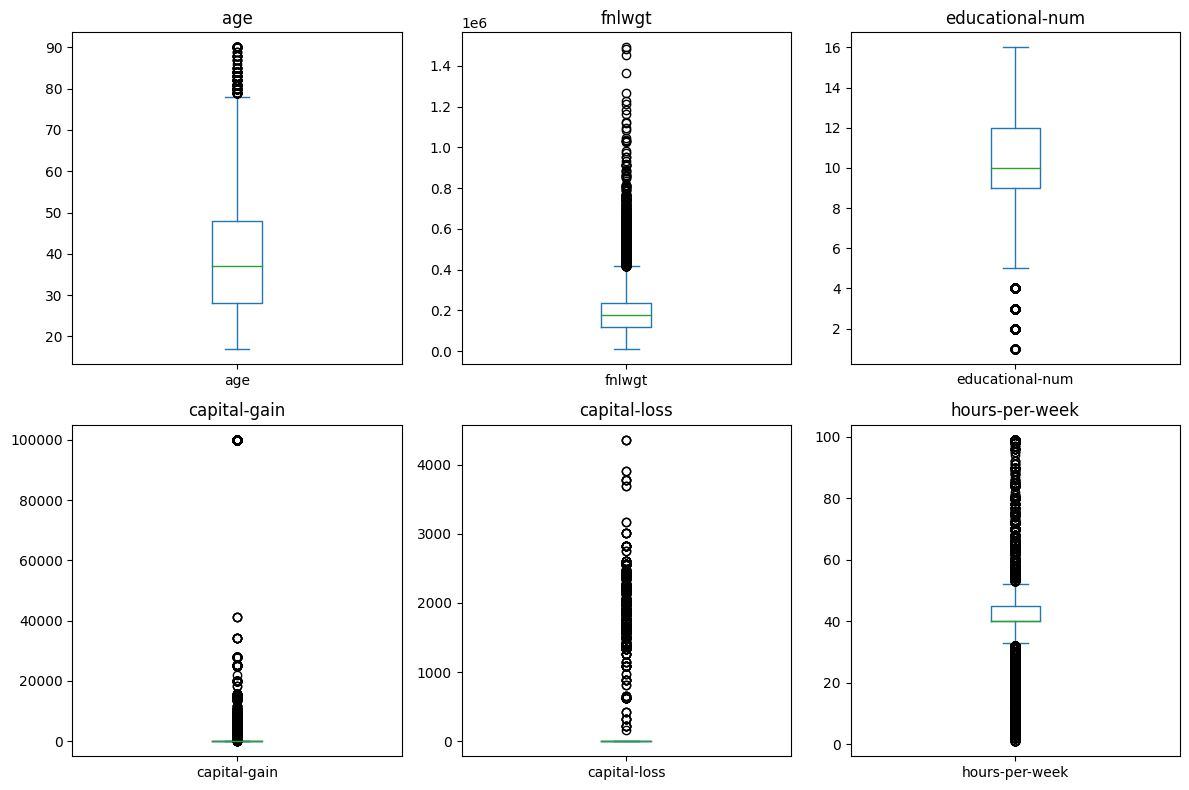

In [ ]:
# Se ejecuta la función getBoxplots para mostrar un gráfico boxplot de cada variable del dataframe
print("Boxplot visualization")
eda.getBoxplots()

### Histograma

Los histogramas son un tipo de gráfica que permiten observar con mayor claridad la distribución de los datos de una variables, en este punto se generará un histograma para cada variable numérica presente en el dataset de partida, a raíz de estos gráficos se pueden extraer las siguientes conclusiones:
* Un gran porcentaje de la población muere a partir de los 40 años con drásticas bajadas.
* La inmensa mayoría de la gente trabaja a tiempo completo con 40 horas semanales.
* Respecto a capital-gain y capital-loss tiene sentido que la inmensa mayoría de la población apenas realice movimientos monetarios de gran tamaño.



Histogram visualization with 10 bins


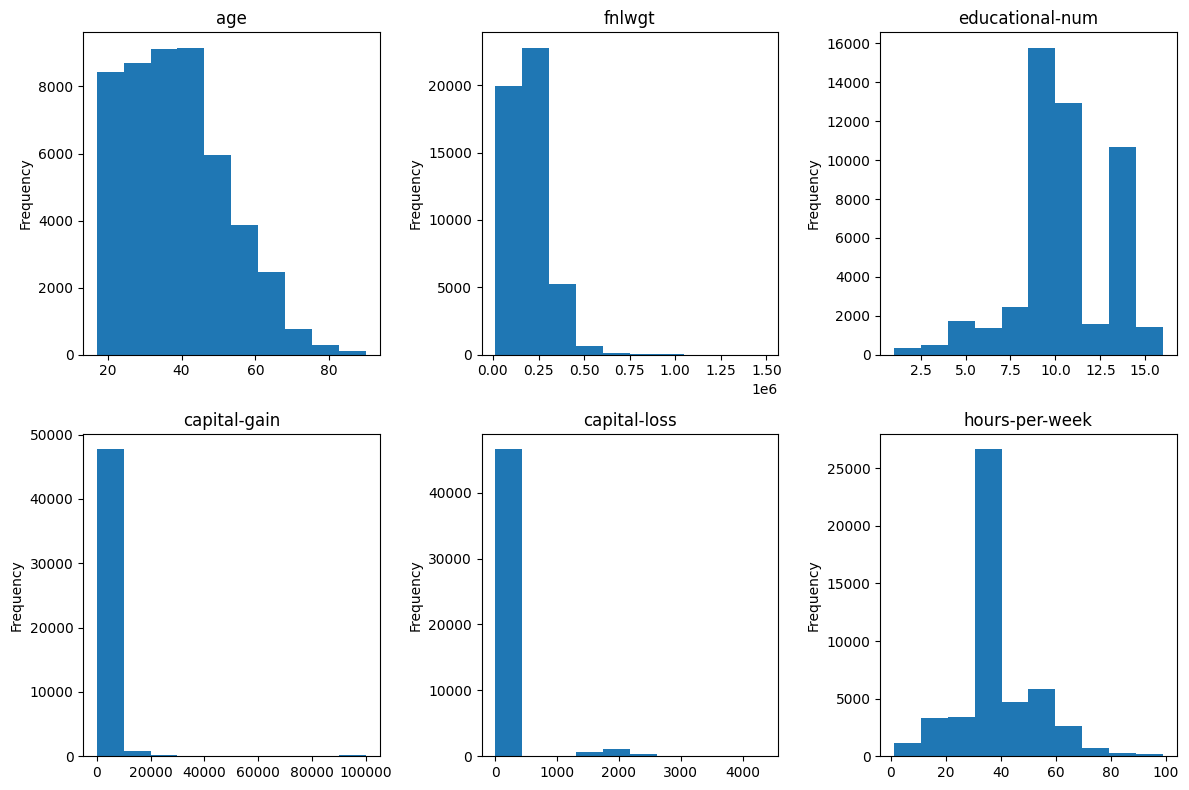

In [ ]:
# Se ejecuta la función getHistograms para mostrar un histograma de 10 bins para cada variable numérica del dataframe
print("Histogram visualization with 10 bins")
eda.getHistograms()

# Detección de Sesgos

Los sesgos son tendencias que pueden introducirse en un modelo debido a datos desbalanceados o a las propias decisiones de diseño y entrenamiento del modelo.
La detección de sesgos es una etapa crucial en el proceso de creación de modelos debido a que un modelo sesgado puede tomar decisiones injustas o discriminatorias, afectando negativamente a ciertos grupos y por tanto reduciendo la precisión general del modelo.

## Análisis de Desigualdades en las Variables

En este punto se estudiará qué variables pueden ser sensibles a la hora de sufrir sesgos, cuáles pueden no ser sensibles a los mismos, cual es el impacto potencial de las posibles variables sensibles y por último se realizará un análisis descriptivo de la presencia de desbalances en las variables sensibles.

### Variables sensibles

A continuación se muestra el listado de posibles variables sensibles a sufrir sesgos:

* Sexo (gender): es una característica que siempre ha sido asociada con desigualdades sociales y económicas. Por ejemplo en muchos trabajos las mujeres han percibido un menor salario por cuestiones de machismo.

* Raza (race): es una variable que ha supuesto discriminación en muchos contextos sociales y laborales. Por ejemplo en muchas oportunidades laborales se han rechazado candidatos de otras razas por prejuicios asociados al racismo.

* Estado Civil (marital-status): puede estar correlacionado con oportunidades económicas y sociales debido a normas culturales. Por ejemplo, individuos casados pueden ser percibidos como personas mas estables y maduras, lo que puede influir en su nivel de ingreso.

* País de Origen (native-country): el país de origen puede implicar la discriminación basada en la nacionalidad o la etnia. Personas de ciertos países pueden ser víctimas de estereotipos basados en la percepción que se tiene de su país, lo cual que afecta a sus oportunidades laborales.

* Edad (age): la edad puede ser un factor muy importante a la hora de ofrecerle un trabajo a un candidato. Por ejemplo, una persona muy mayor puede ser vista como incompetente pese a ser muy hábil en su trabajo debido al edadismo.

### Variables no sensibles

Respecto al resto de variables no creo que puedan sufrir sesgos debido a los siguientes motivos:

* Nivel Educativo (education, educational-num): se trata de un factor objetivo a la hora de predecir ingresos y oportunidades laborales. Aunque pueda verse como un sesgo, tiene sentido que las personas con un mayor nivel educativo puedan desempeñar trabajos de mayor dificultad y consecuentemente percibir mayores ingresos por ello.

* Horas Trabajadas por Semana (hours-per-week): este valor se trata de una simple medida de la cantidad de trabajo realizado y tiene sentido que a más horas trabajada se obtengan mayores ingresos y viceversa.

* Ganancia y Pérdida de Capital (capital-gain, capital-loss): estas variables reflejan las inversiones y pérdidas financieras de un individuo, no tienen nada que ver con las características personales del individuo.

* Ocupación y Clase Trabajadora (occupation, workclass): aunque la ocupación y la clase trabajadora pueden estar influenciadas por otras variables sensibles, en sí mismas son categorías laborales objetivas.

* Peso Final de la Muestra (fnlwgt): simplemente se trata de un ajuste estadístico utilizado para asegurar la representatividad de la muestra, sin relación directa con características demográficas sensibles.

### Impacto potencial

El uso de variables sensibles en modelos predictivos puede resultar en diversos problemas que afectan al rendimiento y reputación del modelo, estas son algunas de las características del potencial impacto que pueden tener este tipo de variables:

* Discriminación: al utilizar variables sensibles en su entrenamiento los modelos pueden aprender patrones históricos de discriminación y replicarlos, perpetuando así las desigualdades existentes. Incluso en función del desbalance y los datos concretos de las variables es posible que el modelo magnifique dichos sesgos.

* Pérdida de Confianza: si el modelo muestra claros casos de discriminación perderá la confianza de sus usuarios y de las entidades que apostaban por él, lo que puede impedir que continúe su uso y desarrollo. Además las organizaciones que implementen modelos valorados como injustos pueden perder su reputación, afectando de manera directa a su negocio.

* Implicaciones Legales y Éticas: utilizar este tipo de variables en el entrenamiento de modelos puede implicar problemas legales si no se tiene un especial cuidado en su tratamiento, desde como se almacenan hasta como se asegura su confidencialidad.


### Análisis descriptivo

En este punto se realizará un análisis descriptivo de cada una de las variables sensibles descritas en apartados anteriores con el objetivo de identificar desigualdades en la distribución de sus datos:

* Gender: en la gráfica se puede apreciar que hay casi un doble de muestras de varones respecto a la cantidad de muestras de mujeres, lo cual puede suponer una menor capacidad de predicción en el caso de las mujeres.

* Race: en esta variable se da un inmenso desbalance en la distribución de sus muestras, los sujetos de raza blanca suponen la abrumadora mayoría de los datos, seguido de un porcentaje muchísimas órdenes menor de personas de raza negra y finalmente el resto de razas con menos de la mitad de muestras respecto a la raza negra. Esto implicará una gran capacidad de acierto para los blancos y un pésimo rendimiento en el caso del resto de razas por no tener apenas muestras de ellas para entrenarse.

* Marital status: la mayoría de los adultos en el conjunto de datos están casados, seguidos de los que nunca se han casado y con un mucho menor porcenataje los que se han divorciado, el resto de valores apenas presentan muestras, lo cual hace muy difícil que el modelo sea capaz de acertar sus predicciones en estos casos.

* Native country: este caso es el más destacado, puesto que más de un 90% de las muestras pertenecen a los estados unidos, dada esta situación en el momento en que un sujeto pertenezca a cualquier otro país obtendrá una predicción con un grado de acierto ínfimo.

* Age: los datos se mantienen estables hasta los 50, a partir de ahí comienza un descenso progresivo de muestras que se intensifica a partir de la edad de jubilación. Estos datos tienen sentido debido al avance de la vejez en el cuerpo de manera progresiva, haciendo que algunas personas ya no puedan desempeñar ciertos trabajos, por lo que al no haber ningún punto particularmente extraño descarto que esta variable pueda pertenecer al grupo de las sensibles.

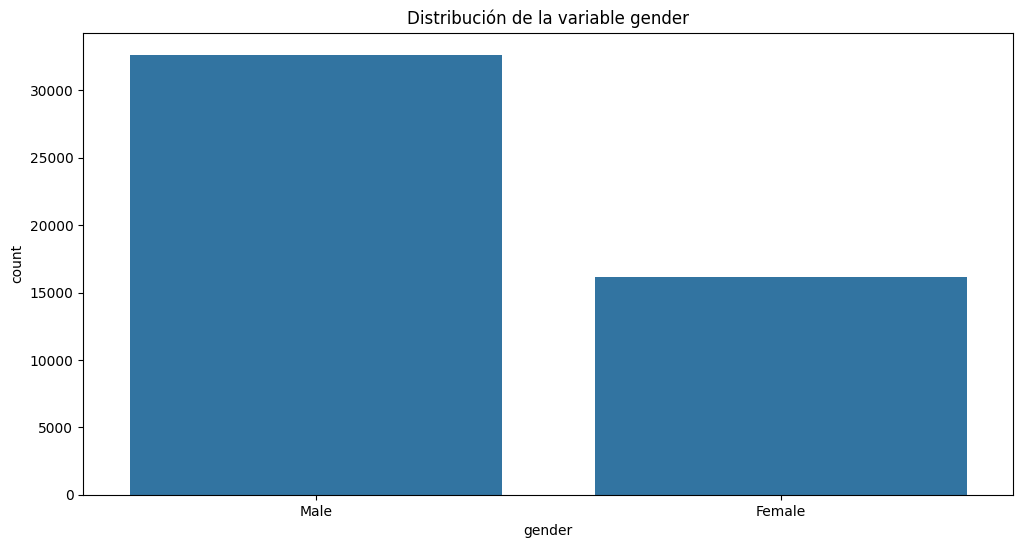

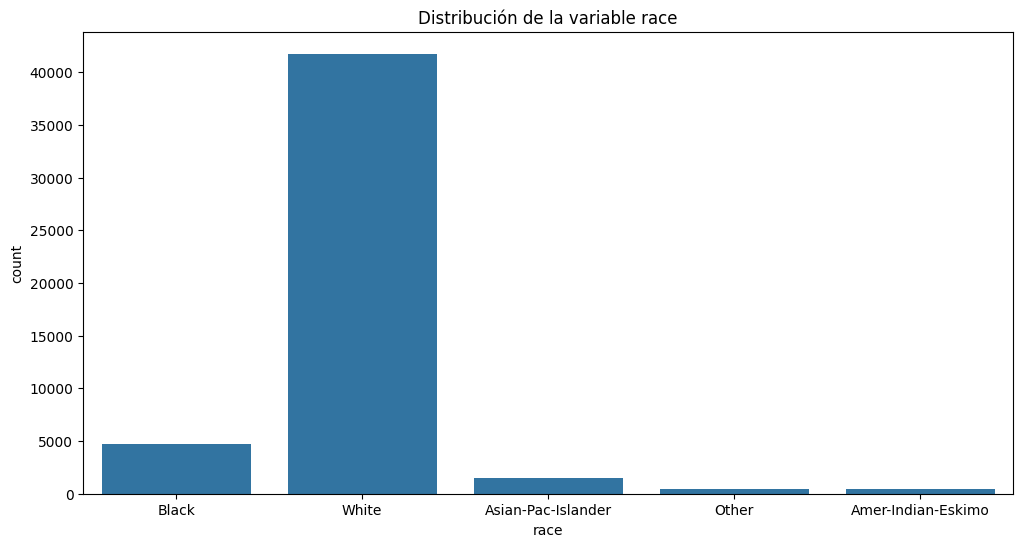

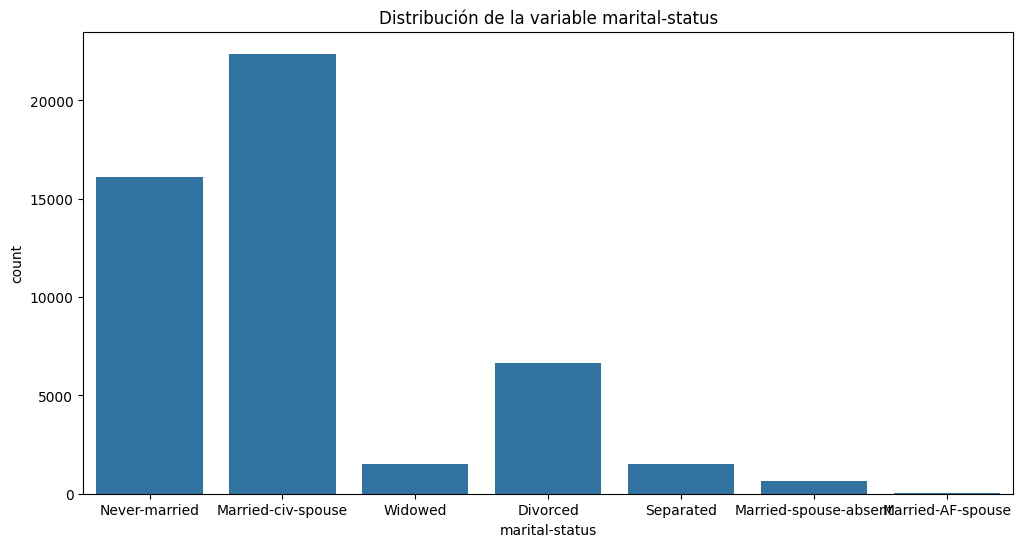

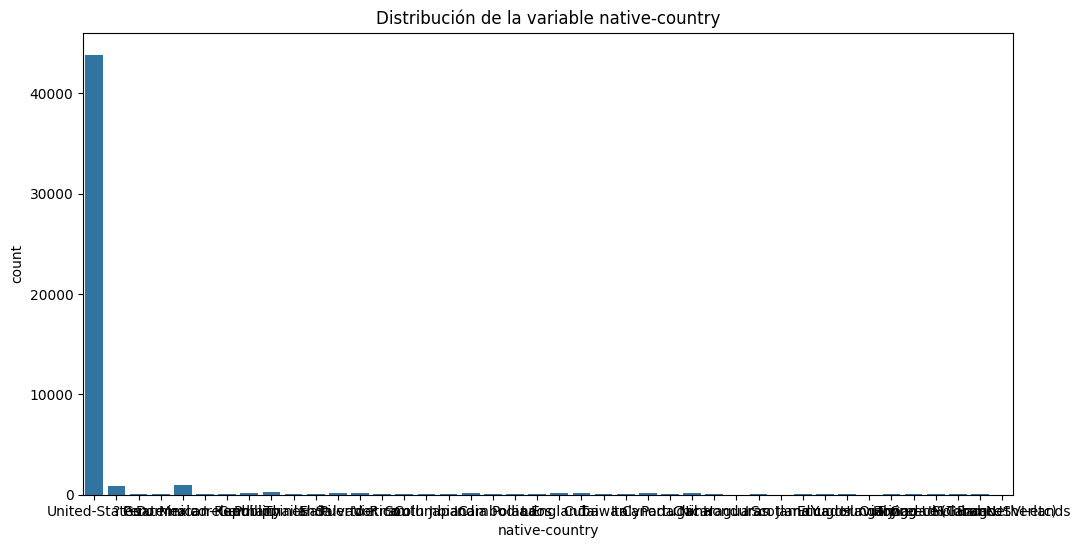

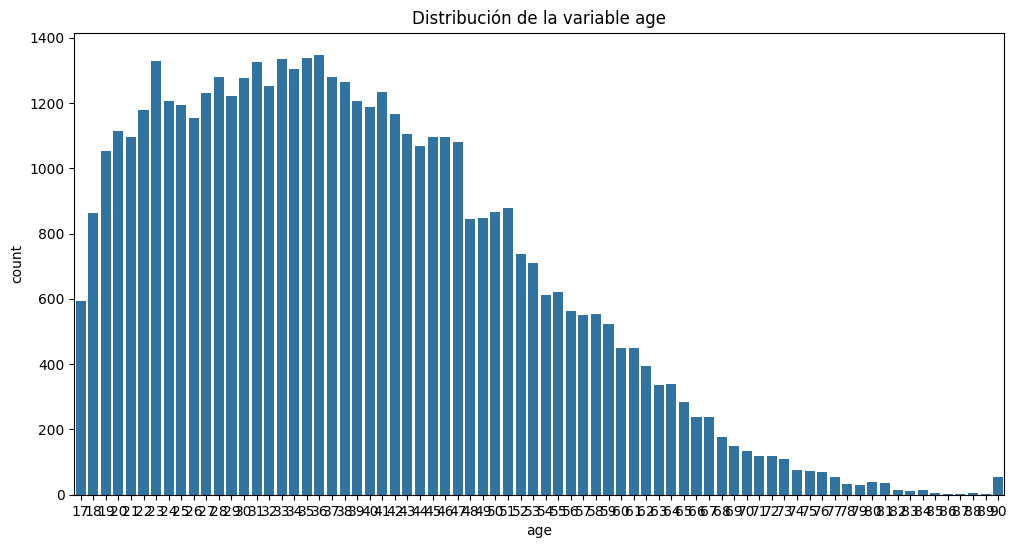

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identificar las variables sensibles
variables_sensibles = ['gender', 'race', 'marital-status', 'native-country', 'age']

# Analizar la distribución de estas variables
for var in variables_sensibles:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=var, data=dataframe)
    plt.title(f'Distribución de la variable {var}')
    plt.show()

## Métrica de Disparate Impact

Disparate Impact se trata de una métrica utilizada para evaluar si un modelo trata de manera desigual a diferentes grupos, en este caso se empleará con los distintos valores de las variables sensibles a sufrir sesgos por parte del modelo.

Antes de calcular el disparate impact de cada grupo, es necesario obtener la tasa de éxito por grupo, que se calcula como la proporción de muestras con ingresos mayores a 50,000. Tras ello se debe determinar la tasa de éxito máxima entre los grupos. Por último, se cuantifica el disparate impact para cada grupo como la relación entre la tasa de éxito del grupo y la tasa de éxito máxima.

Se pueden enunciar las siguientes conclusiones en base al valor obtenido en la métrica para cada variable sensible:
* Gender: las mujeres tienen una tasa de éxito de ingresos altos que es solo el 36% de la tasa de éxito de los hombres, lo cual implica una posible discriminación machista en los ingresos.

* Race: las personas de raza negra y amerindios/eskimos tienen significativamente menores tasas de éxito en comparación con los asiáticos y blancos, indicando un posible sesgo racial en los ingresos.

* Marital status: las personas casadas tienen una mayor tasa de éxito en comparación con los otros estados civiles. Destaca el hecho de que las personas que nunca se han casado tienen la tasa de éxito más baja, percibiendo únicamente el 10% de la tasa de éxito de los casados, lo que sugiere un sesgo basado en el estado civil.

* Native country: se da gran variabilidad en las tasas de éxito según el país de origen. Sin embargo se puede apreciar claramente como los países de sudamérica obtienen una tasa de éxito menor que los países norteamericanos y europeos, lo cual demuestra un sesgo basado en el país de origen.






In [ ]:
# Definir la variable objetivo
target = 'income'

# En vista al punto anterior se elimina 'age' de las variables sensibles
variables_sensibles = ['gender', 'race', 'marital-status', 'native-country']

# Calcular la tasa de éxito para cada grupo en cada variable sensible
for var in variables_sensibles:
    grupos = dataframe[var].unique()
    tasa_exito = {}
    for grupo in grupos:
        tasa_exito[grupo] = dataframe[dataframe[var] == grupo][target].value_counts(normalize=True).get('>50K', 0)

    # Calcular el disparate impact (usando el grupo con la tasa más alta como referencia)
    max_tasa_exito = max(tasa_exito.values())
    disparate_impact = {grupo: tasa / max_tasa_exito for grupo, tasa in tasa_exito.items()}

    # Mostrar los resultados
    print(f'\nDisparate Impact para la variable {var}:')
    for grupo, impact in disparate_impact.items():
        print(f'{grupo}: {impact:.2f}')


Disparate Impact para la variable gender:
Male: 1.00
Female: 0.36

Disparate Impact para la variable race:
Black: 0.45
White: 0.94
Asian-Pac-Islander: 1.00
Other: 0.46
Amer-Indian-Eskimo: 0.43

Disparate Impact para la variable marital-status:
Never-married: 0.10
Married-civ-spouse: 1.00
Widowed: 0.19
Divorced: 0.23
Separated: 0.15
Married-spouse-absent: 0.21
Married-AF-spouse: 0.85

Disparate Impact para la variable native-country:
United-States: 0.58
?: 0.61
Peru: 0.21
Guatemala: 0.08
Mexico: 0.12
Dominican-Republic: 0.12
Ireland: 0.71
Germany: 0.67
Philippines: 0.68
Thailand: 0.40
Haiti: 0.29
El-Salvador: 0.17
Puerto-Rico: 0.26
Vietnam: 0.19
South: 0.41
Columbia: 0.11
Japan: 0.83
India: 0.98
Cambodia: 0.76
Poland: 0.46
Laos: 0.21
England: 0.88
Cuba: 0.59
Taiwan: 0.95
Italy: 0.77
Canada: 0.82
Portugal: 0.43
China: 0.70
Nicaragua: 0.15
Honduras: 0.24
Iran: 0.89
Scotland: 0.34
Jamaica: 0.34
Ecuador: 0.32
Yugoslavia: 0.83
Hungary: 0.75
Hong: 0.63
Greece: 0.87
Trinadad&Tobago: 0.18
Outl

# Modelo de Machine Learning

Un modelo de machine learning consiste en un algoritmo que ha sido entrenado para reconocer patrones en datos, este tipo de modelos se utilizan principalmente para hacer predicciones basadas en datos nuevos.

En este punto se llevará a cabo la limpieza y el preprocesamiento de los datos empleados para entrenar al modelo, tras ello se entrenarán diversos algoritmos para construir varios modelos, que finalmente serán evaluados mediante diversas métricas con el objetivo de seleccionar al que obtenga un mejor rendimiento.

## Limpieza y preprocesamiento

El proceso de limpieza y preprocesado de un conjunto de datos tiene como objetivo optimizarlo para su uso por parte de algoritmos de aprendizaje automático.

La limpieza de datos implica la identificación y la corrección de ciertos valores del conjunto de datos para asegurar su calidad. En este trabajo se aplicará la eliminación de valores atípicos y faltantes.

El preprocesado de datos implica una serie de transformaciones destinados a preparar los datos para facilitar su procesamiento por parte de los algoritmos de machine learning. En este trabajo se llevará a cabo la estandarización de variables numéricas y la codificación de variables categóricas.

### Eliminación o imputación de valores faltantes

La eliminación o imputación de valores faltantes es un proceso utilizado en el análisis de datos para tratar con muestras que tienen valores ausentes. Cuando se encuentran valores faltantes en un conjunto de datos, es necesario abordarlos para que no afecten negativamente al entrenamiento y evaluación del modelo.

En nuestro caso, como se pudo observar en el análisis exploratorio no se encontró ningún valor faltante en el dataset, por lo que no será necesario utilizar ninguna técnica de imputación de valores nulos.

### Estandarización de variables numéricas

La estandarización de variables numéricas tiene como objetivo transformar las variables numéricas para que tengan una media de cero y una desviación estándar de uno. Esto significa que los valores de las variables transformadas estarán centrados alrededor de cero y tendrán una dispersión similar, lo que facilita la comparación y el análisis de las variables.

Para llevar a cabo este proceso se utilizará el algoritmo StandardScaler que implementa la estandarización escalando las características de tal manera que tengan una media de cero y una desviación estándar de uno.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Definir el escalador para las columnas numéricas
num_scaler = StandardScaler()

# Obtener las columnas numéricas excluyendo la columna objetivo
num_cols = dataframe.select_dtypes(include=['int64']).columns.tolist()

# Aplicar el escalado solo a las columnas numéricas
dataframe[num_cols] = num_scaler.fit_transform(dataframe[num_cols])

# Mostrar el DataFrame con las variables numéricas estandarizadas
print(dataframe.head())

        age  workclass    fnlwgt     education  educational-num  \
0 -0.995129    Private  0.351675          11th        -1.197259   
1 -0.046942    Private -0.945524       HS-grad        -0.419335   
2 -0.776316  Local-gov  1.394723    Assoc-acdm         0.747550   
3  0.390683    Private -0.277844  Some-college        -0.030373   
4 -1.505691          ? -0.815954  Some-college        -0.030373   

       marital-status         occupation relationship   race  gender  \
0       Never-married  Machine-op-inspct    Own-child  Black    Male   
1  Married-civ-spouse    Farming-fishing      Husband  White    Male   
2  Married-civ-spouse    Protective-serv      Husband  White    Male   
3  Married-civ-spouse  Machine-op-inspct      Husband  Black    Male   
4       Never-married                  ?    Own-child  White  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0     -0.144804     -0.217127       -0.034087  United-States  <=50K  
1     -0.144804     -0.2

### Codificación de variables categóricas

La codificación de variables categóricas es un proceso que se utiliza para convertir variables categóricas en una forma numérica que los algoritmos de aprendizaje automático pueden entender y utilizar de manera efectiva.

En este apartado se empleará el algoritmo OrdinalEncoder que convierte las características categóricas en números enteros, asignando a cada categoría un valor único en función de un orden específico.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Obtener las columnas categóricas
cat_cols = dataframe.select_dtypes(include=['object']).columns

# Definir el codificador para las columnas categóricas
cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Aplicar la codificación solo a las columnas categóricas
dataframe[cat_cols] = cat_encoder.fit_transform(dataframe[cat_cols])

# Mostrar el DataFrame con las variables categóricas codificadas
print(dataframe.head())

        age  workclass    fnlwgt  education  educational-num  marital-status  \
0 -0.995129        4.0  0.351675        1.0        -1.197259             4.0   
1 -0.046942        4.0 -0.945524       11.0        -0.419335             2.0   
2 -0.776316        2.0  1.394723        7.0         0.747550             2.0   
3  0.390683        4.0 -0.277844       15.0        -0.030373             2.0   
4 -1.505691        0.0 -0.815954       15.0        -0.030373             4.0   

   occupation  relationship  race  gender  capital-gain  capital-loss  \
0         7.0           3.0   2.0     1.0     -0.144804     -0.217127   
1         5.0           0.0   4.0     1.0     -0.144804     -0.217127   
2        11.0           0.0   4.0     1.0     -0.144804     -0.217127   
3         7.0           0.0   2.0     1.0      0.886874     -0.217127   
4         0.0           3.0   4.0     0.0     -0.144804     -0.217127   

   hours-per-week  native-country  income  
0       -0.034087            39.0   

### Detección y eliminación de valores atípicos

Para finalizar el proceso de limpieza de la información solo resta realizar la detección y eliminación de valores atípicos puesto que pueden llegar a distorsionar los resultados del análisis y afectar negativamente el rendimiento de los modelos de aprendizaje automático.

Se utilizarán dos algoritmos de este tipo para la detección de outliers, los cuales buscarán posibles datos anómalos sin la necesidad del entrenamiento con muestras etiquetadas, los algoritmos que se utilizarán son:

Local Outlier Factor (LOF): se basa en la idea de que los valores atípicos tienen una densidad local significativamente menor que la de sus vecinos. LOF calcula un factor de atipicidad para cada instancia en función de la densidad local de sus vecinos, si un punto tiene un factor LOF alto, significa que está menos densamente rodeado que la mayoría de los puntos. Los valores atípicos se identifican como aquellos puntos con un factor LOF significativamente mayor que 1.

Isolation Forest: se basa en el uso de árboles de decisión, se diferencia del método anterior en que no asume que los datos atípicos están necesariamente en áreas de baja densidad. El algoritmo funciona construyendo múltiples árboles de decisión de manera aleatoria, cada árbol divide recursivamente el espacio de características en subconjuntos, seleccionando al azar una característica y un valor de división para cada división. Los valores atípicos se identifican más rápidamente en el proceso de construcción del árbol, ya que necesitan menos divisiones para ser aislados. La puntuación de anomalía se calcula basándose en el promedio de la profundidad de los nodos donde se encuentran los datos, los valores atípicos tendrán puntuaciones de anomalía más bajas.

Después de ejecutar ambos algoritmos, se registra el número de valores atípicos detectados por cada uno y se procede a eliminar aquellos detectados por ambos.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import numpy as np

# Crear el modelo de Local Outlier Factor (LOF)
clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# Crear el modelo de Isolation Forest (IF)
clf_if = IsolationForest(random_state=0)

# Ajustar el modelo LOF a los datos
outliers_lof = clf_lof.fit_predict(dataframe)

# Identificar valores atípicos con LOF
outliers_indices_lof = np.where(outliers_lof == -1)[0]  # Usamos [0] para obtener el array directamente

# Ajustar el modelo IF a los datos
outliers_if = clf_if.fit_predict(dataframe)

# Identificar valores atípicos con IF
outliers_indices_if = np.where(outliers_if == -1)[0]  # Usamos [0] para obtener el array directamente

# Encontrar valores atípicos en común
common_outliers = np.intersect1d(outliers_indices_lof, outliers_indices_if)

# Imprimir resultados
print("Número de valores atípicos detectados por LOF:", len(outliers_indices_lof))
print("Número de valores atípicos detectados por IF:", len(outliers_indices_if))

if len(common_outliers) > 0:
    print("Número de valores atípicos en común:", len(common_outliers))
    # Eliminar valores atípicos en común del conjunto de datos original
    print("Número de entradas en el dataframe original antes de eliminar valores atípicos en común:", dataframe.shape[0])
    dataframe = dataframe.drop(index=dataframe.index[common_outliers])
    print("Número de entradas en el dataframe original después de eliminar valores atípicos en común:", dataframe.shape[0])
else:
    print("\nNo hay valores atípicos en común entre LOF y IF.")

Número de valores atípicos detectados por LOF: 4885
Número de valores atípicos detectados por IF: 7035
Número de valores atípicos en común: 1158
Número de entradas en el dataframe original antes de eliminar valores atípicos en común: 48842
Número de entradas en el dataframe original después de eliminar valores atípicos en común: 47684


## Entrenamiento

El entrenamiento de un modelo de IA es el proceso mediante el cual el modelo aprende a realizar predicciones o tomar decisiones basadas en datos de entrada, para ello el modelo se ajusta a la estrctura y contenido del conjunto de datos de entrada y a las salidas conocidas (etiquetas), utilizando algoritmos de aprendizaje. El objetivo es minimizar el error entre las predicciones del modelo y los valores reales, ajustando los parámetros internos del modelo.

En este apartado se realizará el entrenamiento y evaluación de diversos modelos de IA, para este propósito se emplearán diversos algoritmos de aprendizaje automático. El objetivo es obtener una comparativo del rendimiento de todas las técnicas siendo evaluadas por las mismas métricas.

Respecto a los algoritmos de aprendizaje supervisado que se compararán, dado que se trata de un problema de clasificación binaria, se han elegido los siguientes algoritmos: Decision Tree, K-Nearest Neighbors, Support Vector Classifier y XGBoost. Todos estos métodos comparten una serie de líneas de código comunes necesarias para su ejecución, por ello se creará un método con todos esos aspectos comunes.

Para realizar la división se utilizará la función train_test_split de la biblioteca Scikit-learn, que permite separar las variables predictoras de la variable objetivo is_recid. La división se realiza con una proporción del 70% para el conjunto de entrenamiento y el 30% para el conjunto de prueba, garantizando así que la mayoría de los datos se utilicen para entrenar el modelo, mientras que otra muestra separada de menor tamaño se reserva para evaluar su rendimiento.

La validación es el proceso de evaluar el rendimiento del modelo entrenado utilizando un conjunto de datos diferente al conjunto de entrenamiento, ayuda a verificar si el modelo generaliza bien a datos nuevos y no solo a los datos con los que fue entrenado. La validación se utiliza para ajustar hiperparámetros y evitar problemas como el sobreajuste (overfitting).

La evaluación del rendimiento del modelo se realizará utilizando F1 como métrica de evaluación, que muestra la media entre la precisión y la exhaustividad del modelo, donde la precisión se refiere a la proporción de predicciones positivas correctas entre todas las predicciones positivas, y la exhaustividad se refiere a la proporción de instancias positivas que fueron correctamente identificadas por el modelo entre todas las instancias positivas reales. Además se empleará la matriz de confusión para observar con claridad el número de instancias positivas y negativas clasificadas correcta e incorrectamente.

Evaluación del Modelo:

Evaluación - DecisionTree:

Matriz de Confusión: 



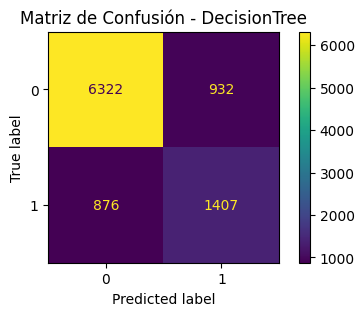

Puntuación F1 (Weighted): 0.8112
Precisión (Weighted): 0.8120
Recall (Weighted): 0.8104

Evaluación - KNeighbors:

Matriz de Confusión: 



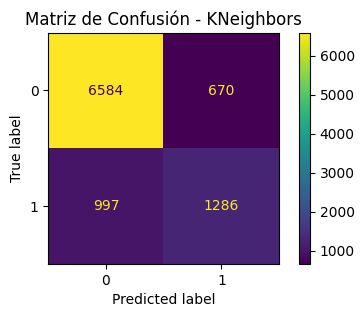

Puntuación F1 (Weighted): 0.8204
Precisión (Weighted): 0.8180
Recall (Weighted): 0.8252

Evaluación - SVC:

Matriz de Confusión: 



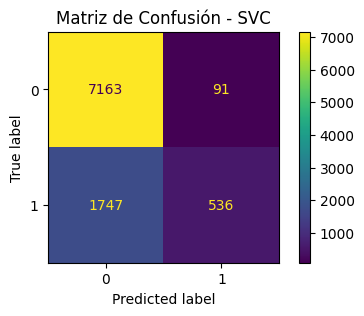

Puntuación F1 (Weighted): 0.7623
Precisión (Weighted): 0.8161
Recall (Weighted): 0.8073

Evaluación - XGBoost:

Matriz de Confusión: 



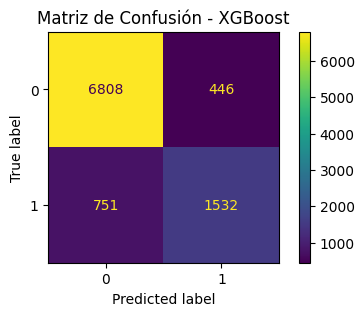

Puntuación F1 (Weighted): 0.8713
Precisión (Weighted): 0.8705
Recall (Weighted): 0.8745

Mejor modelo: XGBoost con Puntuación F1 (Weighted): 0.8713


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Definir los clasificadores y sus nombres
classifiers = {
    'DecisionTree': DecisionTreeClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(probability=True),  # Necesario para que SHAP pueda calcular los SHAP values
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Añadir XGBoost
}

# Función para evaluar modelos y obtener el mejor modelo
def evaluate_models(dataframe, target):
    # Verificar si el DataFrame contiene la columna objetivo
    if target not in dataframe.columns:
        raise ValueError(f"La columna objetivo '{target}' no se encuentra en el DataFrame")

    print("Evaluación del Modelo:\n")

    # Asegurar que la columna objetivo sea binaria
    if dataframe[target].nunique() != 2:
        raise ValueError(f"La columna objetivo '{target}' no es binaria")

    # Separar características y etiquetas
    features = dataframe.drop(columns=[target])
    labels = dataframe[target]

    # Usar una semilla para la reproducibilidad
    seed = 42

    # Realizar una partición train-test
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=seed)

    best_f1_score = -1
    best_model = None
    best_name = None

    for name, classifier in classifiers.items():
        # Crear el clasificador
        pipeline = classifier

        # Entrenar el modelo
        pipeline.fit(X_train, y_train)

        # Predecir en el conjunto de prueba
        y_pred = pipeline.predict(X_test)

        # Calcular la matriz de confusión
        cm = confusion_matrix(y_test, y_pred)

        # Imprimir métricas de evaluación para cada clasificador
        print(f"Evaluación - {name}:\n")
        print("Matriz de Confusión: \n")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Matriz de Confusión - {name}")
        plt.gcf().set_size_inches(5, 3)  # Ajustar el tamaño de la gráfica a 5x3 pulgadas
        plt.show()

        # Calcular e imprimir métricas adicionales
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        print(f"Puntuación F1 (Weighted): {f1:.4f}")
        print(f"Precisión (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}\n")

        # Verificar si este modelo es el mejor hasta ahora
        if f1 > best_f1_score:
            best_f1_score = f1
            best_model = pipeline
            best_name = name

    print(f"Mejor modelo: {best_name} con Puntuación F1 (Weighted): {best_f1_score:.4f}")

    # Retornar el mejor modelo, X_test y y_test para SHAP
    return best_model, X_test, y_test

# Llamar a la función de evaluación de modelos y obtener el mejor modelo y datos de prueba
best_model, X_test, y_test = evaluate_models(dataframe, 'income')

# Interpretación del Modelo y Visualización

Para llevar a cabo la interpretación del modelo entrenado en el punto anterior se utilizará SHAP (SHapley Additive exPlanations), la cual es una técnica de interpretabilidad que facilita el entendimiento de la salida de cualquier modelo de machine learning. SHAP proporciona una medida de la importancia de las variables predictivas, asignando a cada característica un valor que representa su contribución a la predicción del modelo.

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.1 MB/s eta 0:00:00


## Generar SHAP values

En este punto se empleará SHAP para obtener los valores de SHAP(SHAP values) asociados al mejor modelo entrenado en el punto anterior, en este caso se trata de XGBoost. Estos valores son el resultado esta técnica y pueden ser interpretados como el impacto de la presencia de una característica en comparación con su ausencia.

Concretamente los SHAP values consisten en un array de dos dimensiones:

* Primera dimensión (9537): cada entrada representa una instancia en el conjunto de prueba.
* Segunda dimensión (14): cada entrada representa una característica (predictores) del conjunto de datos.

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 6.7 MB/s eta 0:00:00


In [ ]:
import shap

# Inicializar el explainer de SHAP
explainer = shap.TreeExplainer(best_model)

# Calcular los SHAP values para el conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Verificar las dimensiones de shap_values
print("Dimensiones de shap_values:", shap_values.shape)

Dimensiones de shap_values: (9537, 14)


## Importancia de los predictores a nivel global

Lo primero que se debe realizar en este análisis es el estudio del impacto que tiene cada una de las características predictoras en el modelo a la hora de emitir su predicción respecto a la variable objetiva.

Para llevar a cabo este objetivo se utilizará la técnica summary plot de SHAP, la cual genera una gráfica que muestra el efecto de cada variable del conjunto de predictores:
* Eje y: muestra las características, ordenadas por el peso de su influencia en las predicciones.
* Eje x: refleja el efecto de una característica en la salida del modelo.

La gráfica muestra una evolución decreciente en la importancia de las variables desde la primera hasta la última de manera progresiva, con algunos saltos entre grupos de variables, lo que nos permite agruparlas en función de los saltos de diferencia:

* age, relationship y marital-status: la edad y el estado civil son los factores con mayor impacto en la remuneración percibida, tiene sentido ya que una persona con poca o mucha edad puede parecer inadecuada para puestos de gran responsabilidad, mientras que el estado civil aporta confianza para los empleadores, por tanto se puede advertir un fuerte sesgo hacia el estado civil.

* capital-gain y educational-num: ser capaz de tener grandes ganancias de capital y un nivel educativo alto siempre conducirán a obtener mejores las mejores oportunidades laborales.

* occupation y hours-per-week: tiene sentido que el tipo de trabajo y el número de horas dedicadas por el individuo tengan un impacto significativo en el valor del salario que recibe.

* fnlwgt, capital-loss, gender, workclass, race, education y native-country: todas estas características tienen un impacto poco significativo, lo que destaca es que en este grupo aparecen casi todas las variables marcadas como sensibles (gender, race y native-country), lo cual implica que el modelo no posee grandes sesgos hacia estas variables sensibles a la hora de emitir sus predicciones.

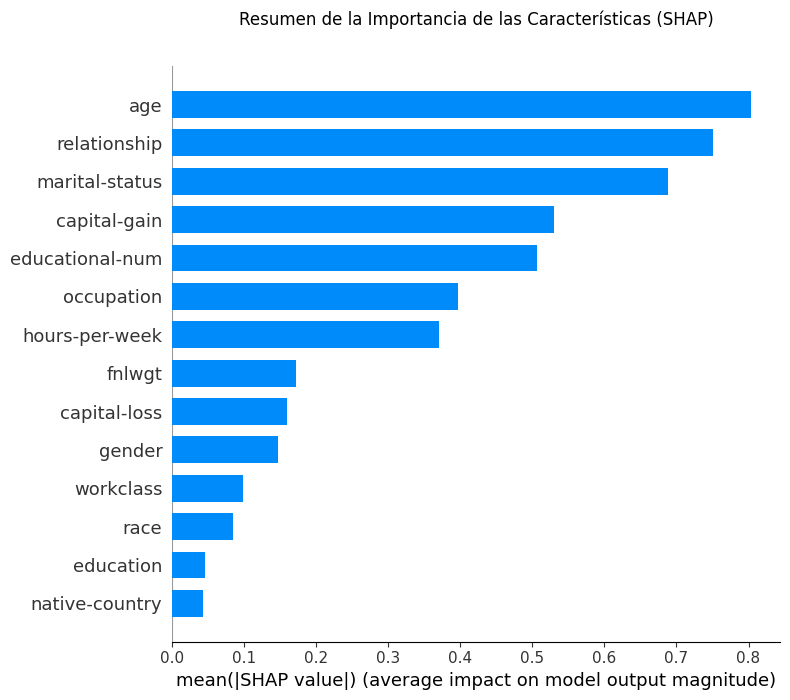

In [ ]:
import matplotlib.pyplot as plt

# Inicializar SHAP
shap.initjs()

# Crear el gráfico de resumen de SHAP
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)

# Ajustar la visualización
plt.title('Resumen de la Importancia de las Características (SHAP)', pad=30)
plt.tight_layout()
plt.show()

## Importancia de los predictores en predicciones individuales.

El waterfall plot de SHAP es una técnica que permite generar una gráfica para visualizar cómo la predicción de un modelo se descompone en contribuciones de características individuales y facilita el entendimiento de cómo cada característica afecta la predicción final para una instancia específica.

El gráfico está compuesto por una serie de barras, en el que cada una representa la contribución de una característica a la predicción de la instancia, las barras que se extienden hacia la derecha aumentan la predicción, mientras que las que se extienden hacia la izquierda la disminuyen.

El color puede indicar la magnitud del valor de la característica (por ejemplo, rojo para valores altos y azul para valores bajos), la longitud de la barra indica la magnitud de la contribución de la característica a la predicción final y las características se ordenan según su contribución, mostrando primero las más influyentes.

En este punto se seleccionarán 4 individuos para conformar el conjunto de sujetos de prueba, para cada uno de ellos se generará un waterfall plot con el objetivo de ver como difiere la influencia de las demás características en función del sujeto seleccionada.

A la vista de las gráficas generadas para cada sujeto seleccionado de forma aleatoria, se puede afirmar que las variables de mayor impacto, tanto negativo como positivo son: age, marital-status, relationship, capital-gain, educational-num, hours-per-week y occupation, las cuales como se estudió en el punto anterior son las 7 variables con mayor peso en las predicciones.

Como conclusión, las variables sensibles no implican un gran impacto en el modelo, puesto que seleccionando individuos aleatorios de distintas características, sus características sensibles no han influenciado en cuales eran sus variables de mayor impacto, siendo estas las de mayor impacto global advertidas en el punto previo.

Waterfall plot para la instancia 1901:


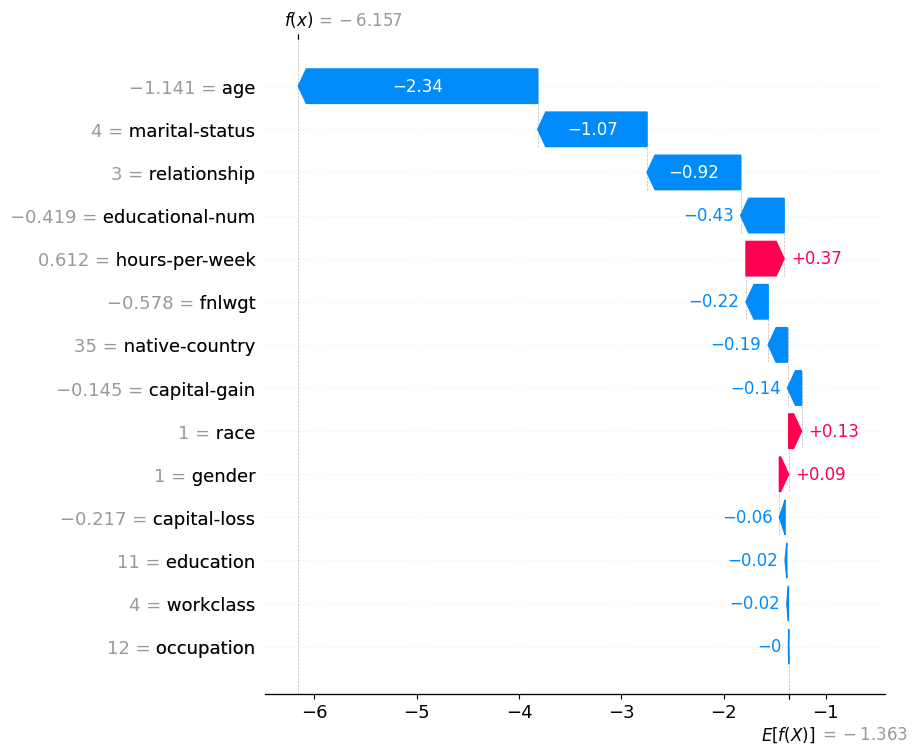

Waterfall plot para la instancia 6232:


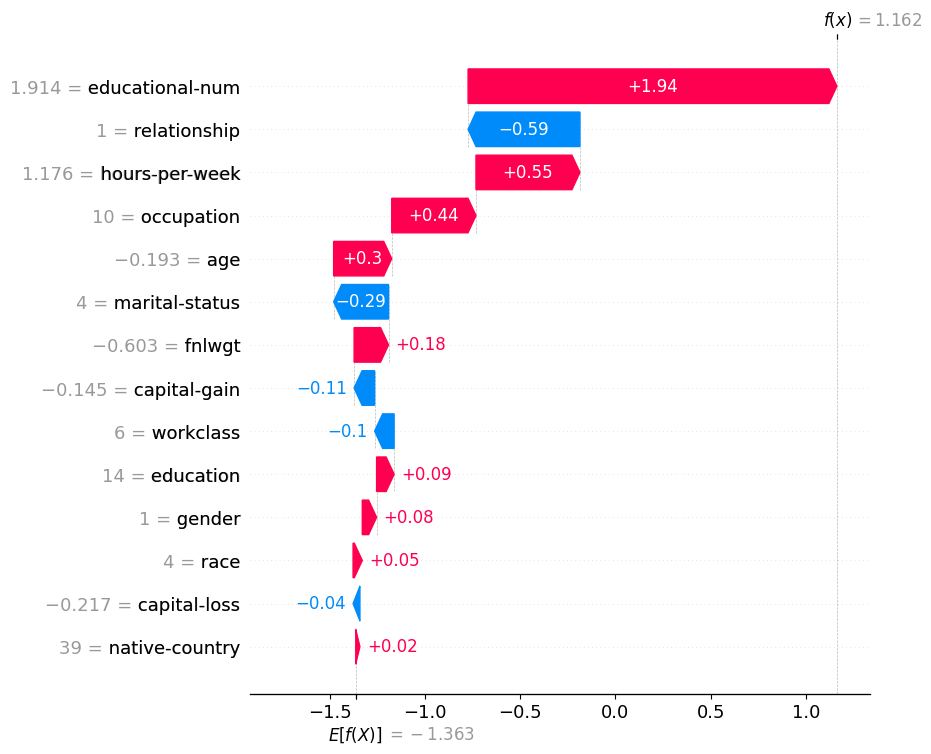

Waterfall plot para la instancia 8098:


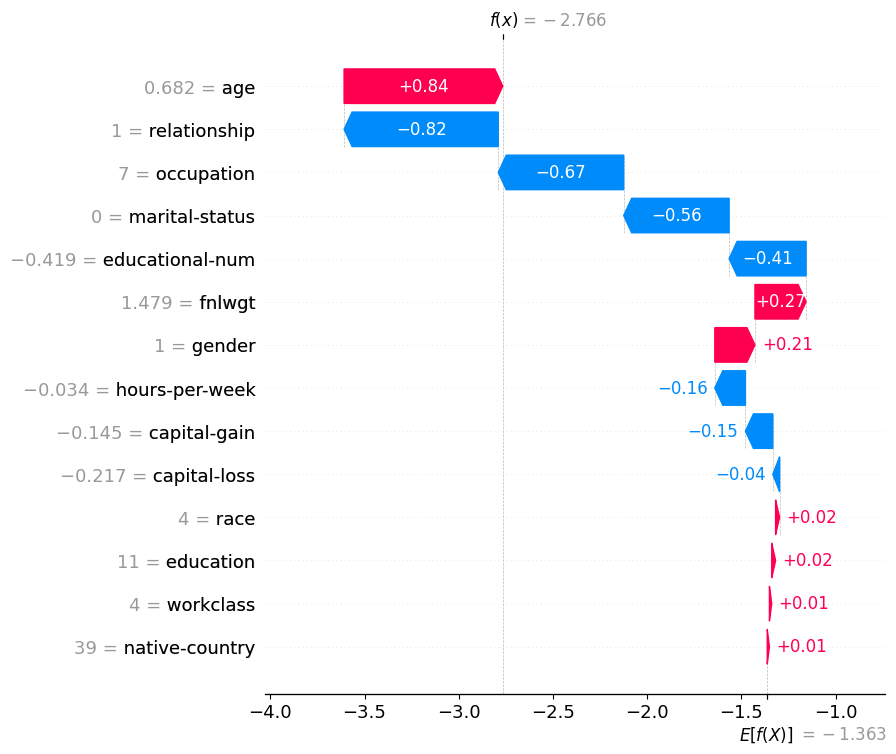

Waterfall plot para la instancia 3146:


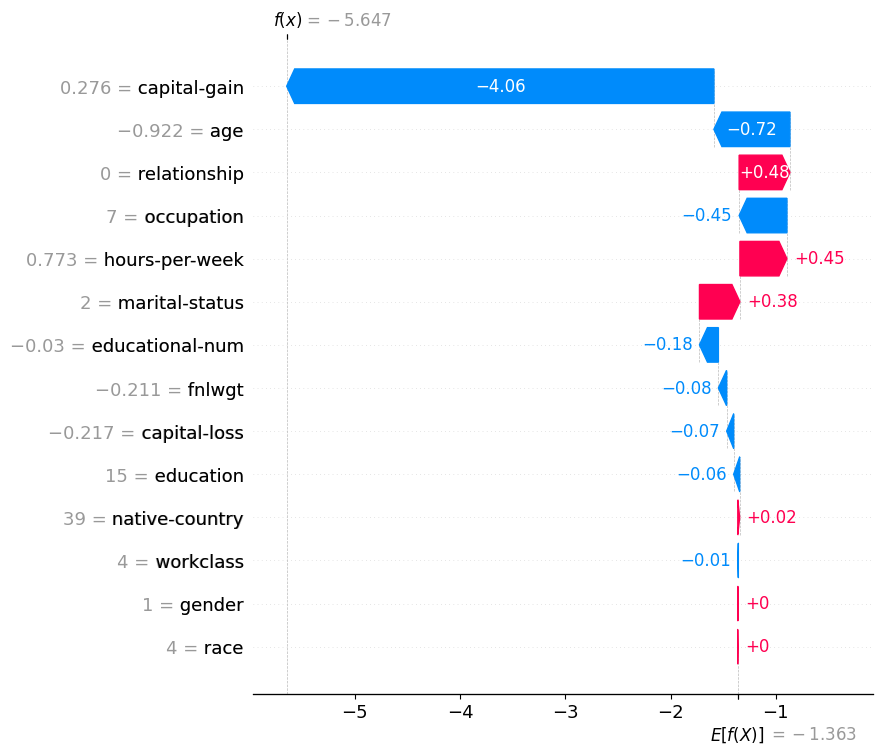

In [ ]:
import random

# Seleccionar cuatro índices aleatorios del conjunto de prueba
num_samples = 4
indices_aleatorios = random.sample(range(X_test.shape[0]), num_samples)

# Visualización individual de la influencia de características
for idx in indices_aleatorios:
    shap_values_instance = shap_values[idx]
    expl = shap.Explanation(values=shap_values_instance, base_values=explainer.expected_value, data=X_test.iloc[idx])

    print(f"Waterfall plot para la instancia {idx}:")
    shap.plots.waterfall(expl, max_display=20)

# Propuestas de Mitigación de Sesgos

En esta sección se abordará la reducción de los sesgos presentes en un modelo, para ello se elaborará un repaso de diversas técnicas que permiten alcanzar este propósito. Además, se implementará una de ellas y se comparará su desempeño con los resultados obtenidos en el modelo construido en puntos anteriores.

## Técnicas

A continuación se expone un listado de técnicas que favorecen la reducción de sesgos a partir de diferentes enfoques.

### Recolección de datos adicionales

Esta propuesta consiste en aumentar el tamaño del conjunto de datos recolectando un mayor número de muestras de aquellos grupos subrepresentados en las distintas variables sensibles. Con un conjunto de datos más equilibrado es posible reducir el sesgo al hacer que el modelo aprenda por igual de todos los grupos.

### Balanceo de datos

Existen diversas técnicas de balanceo que permiten hacer frente a problemas de desequilibrio entre las distintas clases de las variables como:
* Sobremuestreo (oversampling) de minorías que aumenta el número de ejemplos en las clases minoritarias duplicando muestras ya existentes
* Submuestreo (undersampling) de mayorías que reduce el número de ejemplos en las clases mayoritarias eliminando aleatoriamente ejemplos.
* La generación de datos sintéticos (SMOTE) que genera nuevas muestras sintéticas de la clase minoritaria a partir del estudio de ejemplos ya existentes.

Balancear el conjunto de datos puede ayudar a que el modelo no favorezca a los grupos mayoritarios y evalúe de igual modo a todas las clases.

### Postprocesamiento de predicciones



Este tipo de técnicas buscan ajustar las predicciones del modelo tras haber sido entrenado para asegurar que las decisiones finales no perpetúen sesgos presentes en el modelo entrenado. Para ello se emplean técnicas como el ajuste de umbrales que implica modificar los umbrales de decisión del modelo para diferentes grupos sensibles con el fin de equilibrar las tasas de error entre esos grupos.


### Eliminación de variables sensibles

Esta es la estrategia más directa y sencilla, con un enfoque de "matar moscas a cañonazos", que simplemente consiste en eliminar las variables sensibles del conjunto de datos antes de entrenar el modelo para prevenir que este pueda aprender patrones que conduzcan a decisiones discriminatorias.

### Regularización de equidad

Esta idea consiste en incluir términos de penalización en la función de pérdida del modelo que le penalicen las predicciones sesgadas, de este modo se forzaría al modelo a ser justo en sus predicciones evitando que pudiese discriminar en función de cualquier grupo al que pertenezca la muestra.

### Monitoreo continua

La monitorización continua de un modelo permite detectar posibles sesgos en el mismo durante su uso en producción, de modo que el equipo de desarrollo pueda ser notificado rápidamente acerca de cualquier sesgo que deba ser corregido. Para llevar a cabo esta idea se pueden utilizar métricas y dashboards que evalúen continuamente el rendimiento del modelo para diferentes grupos de variables sensibles.

## Implementación

Tras la explicación de diversos métodos de mitigación de sesgos, ha llegado la hora de implementar una de dichas técnicas, en este caso se ha seleccionado el algoritmo  SMOTE (Synthetic Minority Over-sampling Technique) que, como ya se comentó, permite generar nuevas muestras sintéticas de la clase minoritaria a partir de datos ya presentes.

Una vez han sido balanceados los datos, se invoca a la función desarrollada en el punto de entrenamiento, que permitirá entrenar diversos modelos con el conjunto de datos balanceado y evaluar su rendimiento a partir de diversas métricas.

A la vista de los resultados, se pueden enunciar las siguientes comparativas sobre los distintos modelos evaluados:
* DecisionTree: su puntuación F1 ha mejorado de 0.8112 a 0.8538
* KNeighbors: su puntuación F1 se ha incrementado de 0.8204 a 0.8564
* SVC: su puntuación F1 ha aumentado de 0.7623 a 0.7900
* XGBoost: su puntuación F1 ha progresado de 0.8713 a 0.9006

En este caso, se ha demostrado que la implementación de técnicas de mitigación de sesgos puede aumentar el rendimiento de los modelos de aprendizaje automático, por no mencionar las repercusiones que tienen en la mejora de la credibilidad del modelo por parte de los usuarios y otras entidades interesadas en su uso.

Evaluación del Modelo:

Evaluación - DecisionTree:

Matriz de Confusión: 



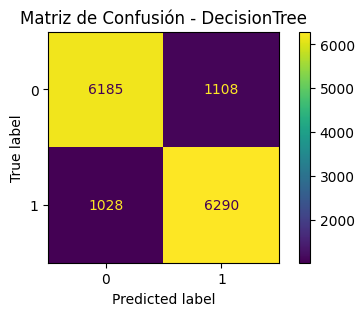

Puntuación F1 (Weighted): 0.8538
Precisión (Weighted): 0.8538
Recall (Weighted): 0.8538

Evaluación - KNeighbors:

Matriz de Confusión: 



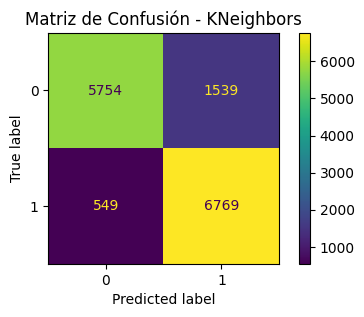

Puntuación F1 (Weighted): 0.8564
Precisión (Weighted): 0.8637
Recall (Weighted): 0.8571

Evaluación - SVC:

Matriz de Confusión: 



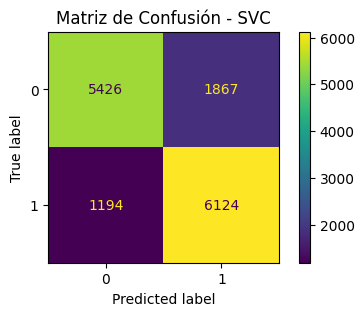

Puntuación F1 (Weighted): 0.7900
Precisión (Weighted): 0.7930
Recall (Weighted): 0.7905

Evaluación - XGBoost:

Matriz de Confusión: 



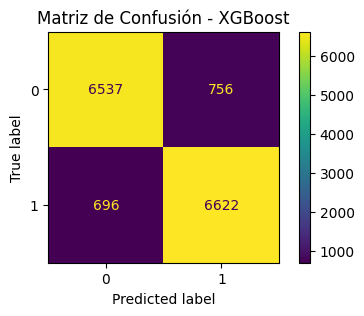

Puntuación F1 (Weighted): 0.9006
Precisión (Weighted): 0.9006
Recall (Weighted): 0.9006

Mejor modelo: XGBoost con Puntuación F1 (Weighted): 0.9006


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=None, ...),
             age  workclass    fnlwgt  education  educational-num  \
 11124  0.244808        7.0 -0.101959       12.0         1.525474   
 37541 -1.578629        0.0 -0.268981        0.0        -1.586221   
 27998  2.141183  

In [ ]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(dataframe.drop(columns=[target]), dataframe[target])

# Agregar las características balanceadas al DataFrame original
dataframe_balanced = pd.DataFrame(X_balanced, columns=dataframe.drop(columns=[target]).columns)
dataframe_balanced[target] = y_balanced

# Llamar a la función para evaluar modelos con los datos balanceados
evaluate_models(dataframe_balanced, target)

# Conclusión

Realizar esta práctica ha supuesto el culmen a todo lo aprendido en términos de análisis y detección de sesgos, así como interpretabilidad de modelos. Además en este trabajo he tenido la oportunidad de combinar un gran conjunto de técnicas, tanto para estudiar y preprocesar los datos de partida, como para crear modelos que puedan emitir predicciones con un buen grado de confianza.

Por último, he podido ampliar mis conocimientos sobre propuestas de reducción de sesgos, además de demostrar la eficacia de una de ellas llevándola a cabo  junto a la creación de un nuevo modelo que supera al anterior (ante el cual no se habían aplicado técnicas de mitigación de sesgos).